<a href="https://colab.research.google.com/github/sgayangi/Anomalies-in-Gastrointestinal-CNN-TL/blob/master/VGG19_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import applications
from tensorflow.keras import optimizers

In [2]:
!wget --no-check-certificate \
  https://datasets.simula.no/kvasir/data/kvasir-dataset-v2-folds-features.zip\
  -O /tmp/kvasir-dataset-v2-features.zip

--2021-03-06 08:53:30--  https://datasets.simula.no/kvasir/data/kvasir-dataset-v2-folds-features.zip
Resolving datasets.simula.no (datasets.simula.no)... 128.39.36.14
Connecting to datasets.simula.no (datasets.simula.no)|128.39.36.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 98573500 (94M) [application/zip]
Saving to: ‘/tmp/kvasir-dataset-v2-features.zip’

/tmp/kvasir-dataset 100%[===================>]  94.01M  5.78MB/s    in 16s     

2021-03-06 08:53:47 (5.90 MB/s) - ‘/tmp/kvasir-dataset-v2-features.zip’ saved [98573500/98573500]



In [3]:
!wget --no-check-certificate \
  https://datasets.simula.no/kvasir/data/kvasir-dataset-v2.zip\
  -O /tmp/kvasir-dataset-v2.zip

--2021-03-06 08:53:47--  https://datasets.simula.no/kvasir/data/kvasir-dataset-v2.zip
Resolving datasets.simula.no (datasets.simula.no)... 128.39.36.14
Connecting to datasets.simula.no (datasets.simula.no)|128.39.36.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2489312085 (2.3G) [application/zip]
Saving to: ‘/tmp/kvasir-dataset-v2.zip’

/tmp/kvasir-dataset 100%[===================>]   2.32G  4.05MB/s    in 11m 36s 

2021-03-06 09:05:24 (3.41 MB/s) - ‘/tmp/kvasir-dataset-v2.zip’ saved [2489312085/2489312085]



In [4]:
datadir='/tmp/kvasir-dataset-v2'
categories = ['dyed-lifted-polyps','dyed-resection-margins','esophagitis',
             'normal-cecum','normal-pylorus','normal-z-line','polyps','ulcerative-colitis']

In [5]:
import os
import zipfile

local_zip = '/tmp/kvasir-dataset-v2.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

In [6]:
training_data=[]
def create_training_data():
    for category in categories:
        path = os.path.join(datadir,category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img))
                new_array = cv2.resize(img_array,(224,224))
                training_data.append([new_array,class_num])
            except Exception as e:    
                pass
create_training_data()

In [7]:
y=[]
x=[]

for features,label in training_data:
    x.append(features)
    y.append(label)
x = np.array(x)
print(x.shape)

(8000, 224, 224, 3)


In [8]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=42)

In [9]:
x_train=np.array(x_train, dtype=np.float32)
x_test=np.array(x_test, dtype=np.float32)
x_train/=255.0
x_test/=255.0

In [10]:
y_train = tf.keras.utils.to_categorical(y_train, 8)
y_test = tf.keras.utils.to_categorical(y_test, 8)

In [11]:
# local_weights_file = '/tmp/kvasir-cnn-v1.1.h5'
# new_model = tf.keras.models.load_model(local_weights_file)

model = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (224, 224, 3))

80142336/80134624 [==============================] - 0s 0us/step


In [12]:
for layer in model.layers[:30]:
    layer.trainable = True
x = model.output
x =  tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
predictions = tf.keras.layers.Dense(8, activation="softmax")(x)   
model_final = tf.keras.models.Model(model.input,predictions)
model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

In [13]:
history=model_final.fit(x_train, y_train,
          batch_size=32,
          epochs=50,
          verbose=1,
          validation_data=(x_test, y_test))

Epoch 1/50
175/175 [==============================] - 134s 529ms/step - loss: 1.8147 - accuracy: 0.2852 - val_loss: 0.7627 - val_accuracy: 0.6858
Epoch 2/50
175/175 [==============================] - 98s 560ms/step - loss: 0.7980 - accuracy: 0.6697 - val_loss: 0.5005 - val_accuracy: 0.8067
Epoch 3/50
175/175 [==============================] - 98s 558ms/step - loss: 0.5373 - accuracy: 0.7929 - val_loss: 0.4791 - val_accuracy: 0.8100
Epoch 4/50
175/175 [==============================] - 98s 562ms/step - loss: 0.4388 - accuracy: 0.8329 - val_loss: 0.4487 - val_accuracy: 0.8238
Epoch 5/50
175/175 [==============================] - 98s 561ms/step - loss: 0.3789 - accuracy: 0.8536 - val_loss: 0.3764 - val_accuracy: 0.8550
Epoch 6/50
175/175 [==============================] - 98s 561ms/step - loss: 0.3170 - accuracy: 0.8714 - val_loss: 0.3293 - val_accuracy: 0.8658
Epoch 7/50
175/175 [==============================] - 98s 561ms/step - loss: 0.2714 - accuracy: 0.8930 - val_loss: 0.3358 - val_a

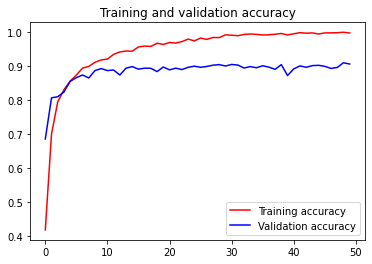

<Figure size 432x288 with 0 Axes>

In [15]:
model.save('vgg-19-model-weights-v2.h5')

import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()